In [1]:
import sys
sys.path.append("../src")

import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.widgets as sw
import numpy as np
import time
import shutil
from pathlib import Path

from deepinterpolation_recording import DeepInterpolatedRecording


%matplotlib widget

/home/buccino/miniconda3/envs/si/lib/python3.8/site-packages/h5py/__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters


In [2]:
#sw.set_default_plotter_backend("ipywidgets")

In [3]:
rec_file = "/home/buccino/data/Neuropixels2.0_Recording/open-ephys-np2/595262_2022-02-22_16-47-26/"

In [4]:
rec = se.read_openephys(rec_file)

In [5]:
rec

OpenEphysBinaryRecordingExtractor: 384 channels - 1 segments - 30.0kHz - 616.720s

In [6]:
rec.get_dtype()

dtype('int16')

FILTERING AND ZSCORING

In [7]:
model = "../trained_models/test_training_no_hp_filter_t20s_v0.5s/first_test_unet_single_ephys_1024_mean_absolute_error_model.h5"

In [8]:
recording_filtered = spre.bandpass_filter(rec)
#rec=si.load_extractor("recording_rescaled_di_bp/")

In [9]:
from spikeinterface.core import get_random_data_chunks
random_data = get_random_data_chunks(recording_filtered)
means = np.mean(random_data, axis=0)
means = means[None, :]
stds = np.std(random_data, axis=0)
stds = stds[None, :] 
gain = stds # gain should be the stds
#gain_hp_filter= gain
offset = -means / stds
#offset_hp_filter= offset

In [10]:
print(gain)

[[ 52.98711472  56.00750479  57.00047913  55.84342721  55.94581216
   55.99659981  57.52534338  57.64604462  62.12885885  58.35685839
   62.45369261  60.93391637  65.21588919  63.35438268  65.99598168
   65.04596078  66.7634637   68.3399207   68.47450927  73.26139024
   66.12312827  68.4596288   65.92460321  69.73972879  68.08593176
   76.53166843  71.76918564  80.54189204  78.50944324  77.97251024
   83.58103251  80.16917115  92.28257619  86.80983698 104.35802441
   94.23826594 102.6901165   96.74864827  97.43496946  96.84819615
   88.58458888  97.28333869  88.52956497  96.5159757   85.79025675
   92.65559709  83.9213916   89.04149853  82.57925569  88.95072618
   86.98685544  87.39583475  76.94787918  84.52053267  64.51526194
   75.97193018  60.16087804  71.72642061  58.8724579   66.84083817
   56.64376306  62.97622638  56.3629679   59.82758407  57.87222607
   57.99817883  56.95331934  56.97014489  55.99075674  55.96560166
   56.99709739  56.47831529  57.13945223  57.01999957  58.4527

In [11]:
recording_filtered_z = spre.zscore(recording_filtered)

In [12]:
test_start_s = 0
test_end_s = 10
fs = rec.sampling_frequency

start_frame = int(test_start_s* fs)
end_frame = int(test_end_s* fs)

### Test GPU

In [13]:
use_gpu = True

In [14]:
rec_di_gpu = DeepInterpolatedRecording(recording_filtered_z, model, use_gpu=True, memory_gpu=512)
rec_di = rec_di_gpu

/home/buccino/miniconda3/envs/si/lib/python3.8/site-packages/Keras_Preprocessing-1.1.2-py3.8.egg/keras_preprocessing/image/utils.py:23: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
/home/buccino/miniconda3/envs/si/lib/python3.8/site-packages/Keras_Preprocessing-1.1.2-py3.8.egg/keras_preprocessing/image/utils.py:24: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
/home/buccino/miniconda3/envs/si/lib/python3.8/site-packages/Keras_Preprocessing-1.1.2-py3.8.egg/keras_preprocessing/image/utils.py:25: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
/home/buccino/miniconda3/envs/si/lib/python3.8/site-packages/Keras_Preprocessing-1.1.2-py3.8.egg/keras_preprocessi

In [15]:
#rec_di = spre.bandpass_filter(rec_di)

In [16]:
#rec_di_one = recording_di_bp_filter_rescaled.select_segments(0)
#rec_di_slice = rec_di_one.frame_slice(start_frame=start_frame, end_frame=end_frame)

In [17]:
rec_norm_no_hp = spre.bandpass_filter(rec_di)

In [18]:
recording_rescaled= spre.scale(rec_norm_no_hp, gain= gain, offset= -offset, dtype='float') #gain should be the stds
#recording_rescaled= spre.scale(rec_di, gain= gain, offset= -offset, dtype='float') #gain should be the stds

In [19]:
recording_rescaled.get_dtype()

dtype('float64')

In [20]:
traces_or = recording_filtered.get_traces(start_frame=3000, end_frame=13005)
traces_or.shape

(10005, 384)

In [21]:
traces_processed = recording_rescaled.get_traces(start_frame=3000, end_frame=13005)

/home/buccino/miniconda3/envs/si/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


/home/buccino/miniconda3/envs/si/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


Text(0.5, 1.0, 'Difference')

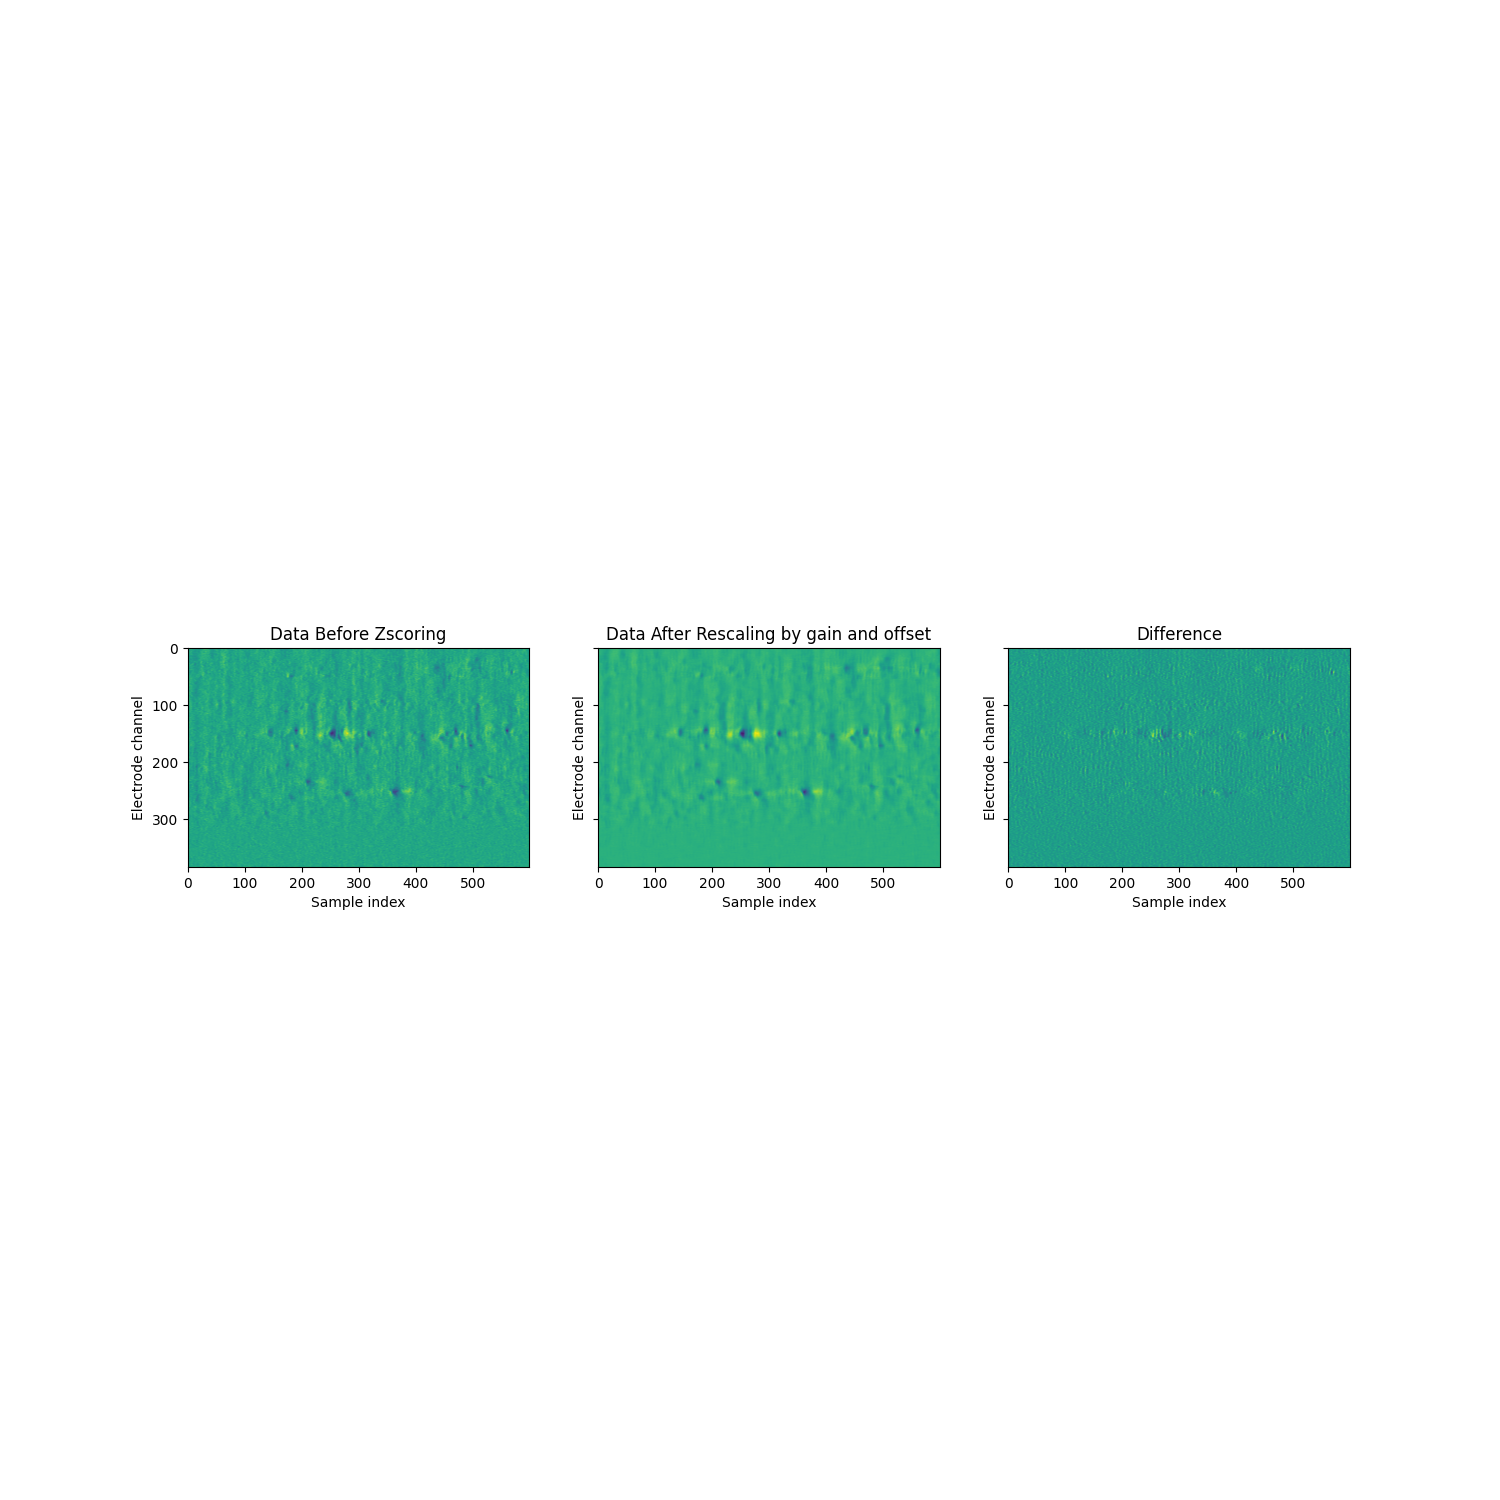

In [22]:
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(15, 15))

diff_bp_di = traces_or - traces_processed

ax1.imshow(traces_or[:600].T)
ax2.imshow(traces_processed[:600].T)
ax3.imshow(diff_bp_di[:600].T)

ax1.set_xlabel('Sample index')
ax1.set_ylabel('Electrode channel')
ax1.set_title('Data Before Zscoring')

ax2.set_xlabel('Sample index')
ax2.set_ylabel('Electrode channel')
ax2.set_title('Data After Rescaling by gain and offset')

ax3.set_xlabel('Sample index')
ax3.set_ylabel('Electrode channel')
ax3.set_title('Difference')

#fig.suptitle('Comparison between original and predicted -bandpass then deepinterpolation filtering- segment, for Neuropixels2.0')
#plt.subplots_adjust(top=1)

#plt.savefig('/home/buccino/Visual Results/Spikeinterface/Neuropixels1.0/Visual graph/Comparison between original and predicted -bandpass then deepinterpolation filtering- segment, for Neuropixels2.0 recording.png')

In [23]:
recording_rescaled= spre.scale(recording_rescaled, gain= 1, offset= 1, dtype='int16')

In [24]:
chunk_duration = "50ms"
#n_jobs = 4

Caution: make sure to change the name of the section

In [25]:
output_folder = Path("recording_rescaled_di_bp")
if output_folder.is_dir():
    shutil.rmtree(output_folder)

In [28]:
chunk_duration = "50ms"
n_jobs = 8

t_start = time.perf_counter()
rec_saved_gpu = recording_rescaled.save(folder=output_folder, n_jobs=n_jobs, progress_bar=True, 
                                  chunk_duration=chunk_duration)
t_stop = time.perf_counter()
elapsed_gpu = t_stop - t_start
print(f"Elapsed GPU with {n_jobs} jobs - chunk {chunk_duration}: {np.round(elapsed_gpu, 2)}")

write_binary_recording with n_jobs = 8 and chunk_size = 1500


/home/buccino/miniconda3/envs/si/lib/python3.8/site-packages/h5py/__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters
/home/buccino/miniconda3/envs/si/lib/python3.8/site-packages/h5py/__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters
/home/buccino/miniconda3/envs/si/lib/python3.8/site-packages/h5py/__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters
/home/buccino/miniconda3/envs/si/lib/python3.8/site-packages/h5py/__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters
/home/buccino/miniconda3/envs/si/lib/python3.8/site-packages/h5py/__init__.py:46: DeprecationWarning: `n

write_binary_recording:   0%|          | 0/12335 [00:00<?, ?it/s]

/home/buccino/miniconda3/envs/si/lib/python3.8/site-packages/h5py/__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters
/home/buccino/miniconda3/envs/si/lib/python3.8/site-packages/h5py/__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters
/home/buccino/miniconda3/envs/si/lib/python3.8/site-packages/h5py/__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters
/home/buccino/miniconda3/envs/si/lib/python3.8/site-packages/Keras_Preprocessing-1.1.2-py3.8.egg/keras_preprocessing/image/utils.py:23: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
/home/buccino/miniconda3

Elapsed GPU with 8 jobs - chunk 50ms: 12615.08


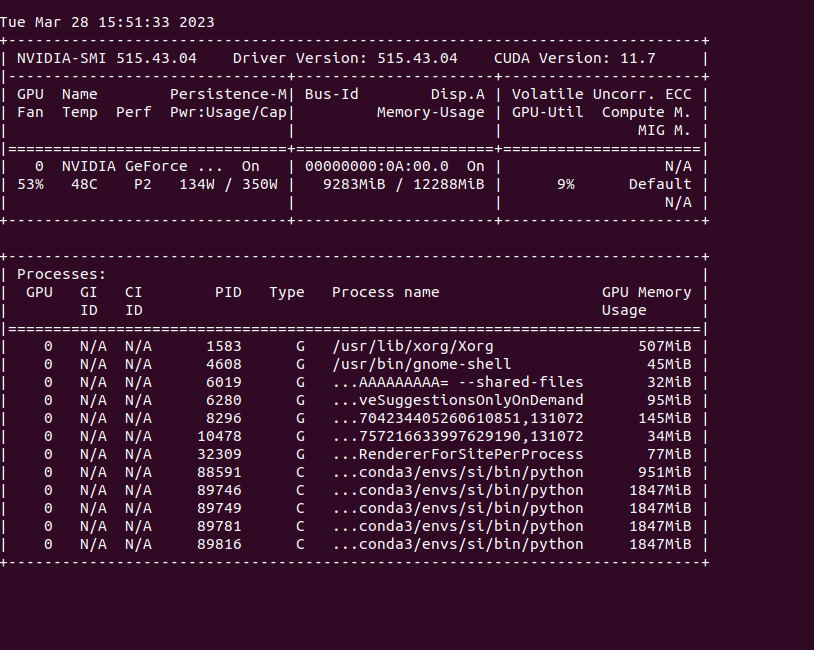

ASSESSING QUALITY OF RESULTS

In [30]:
rec_test_1=si.load_extractor("recording_rescaled_di_bp/")

In [31]:
rec_test_1

BinaryFolderRecording: 384 channels - 1 segments - 30.0kHz - 616.720s

In [32]:
from spikeinterface.core import get_random_data_chunks
random_data_test = get_random_data_chunks(rec_test_1)
means_test = np.mean(random_data_test, axis=0)
means_test = means_test[None, :]
stds_test = np.std(random_data_test, axis=0)
stds_test = stds_test[None, :] 
gain_test = stds_test # gain should be the stds
#gain_hp_filter= gain
offset_test = -means_test / stds_test
#offset_hp_filter= offset
print(gain_test)

[[ 27.84576663  28.95011813  32.86501278  34.30560682  37.52470905
   38.88257652  40.98509627  41.86263392  47.11609585  44.7174052
   48.3196592   47.60077903  51.10008786  50.76930326  51.86113505
   51.14978256  52.62073125  52.4920034   51.37935242  53.26322829
   48.51286583  49.78202504  48.68492979  50.31832564  52.22926151
   56.48180489  58.3520887   61.4671444   67.5758682   64.04155589
   76.91251521  69.96258555  94.26317962  81.58135509 111.8615227
   96.48693991 107.61135029 104.39802096  92.74146087 103.12685285
   78.65701157 101.01589     73.67287561  98.08769636  67.72363222
   91.09267853  64.46716363  79.64923766  60.73626195  73.74575766
   61.8222405   68.29533474  52.71855852  64.96653075  44.28688404
   57.26646145  42.00447447  54.06958241  40.56929816  49.90270941
   39.15283321  46.55694559  38.18587973  42.59790882  38.67956102
   40.72258421  37.65166735  39.78254426  36.80735293  38.54861141
   37.04718076  38.0215522   36.77676343  38.67229571  36.9
   3

### Test CPU

In [ ]:
use_gpu = False

In [ ]:
rec_di_cpu = DeepInterpolatedRecording(rec_hp, model_hp_path, use_gpu=use_gpu)
rec_di = rec_di_cpu

In [ ]:
rec_di_one = rec_di.select_segments(0)
rec_di_slice = rec_di_one.frame_slice(start_frame=start_frame, end_frame=end_frame)

In [ ]:
chunk_duration = "50ms"
n_jobs = 12

In [ ]:
output_folder = Path("test_multi_di_cpu")
if output_folder.is_dir():
    shutil.rmtree(output_folder)

In [ ]:
t_start = time.perf_counter()
rec_save = rec_di_slice.save(folder=output_folder, n_jobs=n_jobs, progress_bar=True, 
                             chunk_duration=chunk_duration)
t_stop = time.perf_counter()
elapsed_cpu = t_stop - t_start
print(f"Elapsed CPU with {n_jobs} jobs - chunk {chunk_duration}: {np.round(elapsed_cpu, 2)}")

In [ ]:
sw.plot_timeseries(rec_hp, clim=(-3, 3), segment_index=0)